In [2]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

import matplotlib.pyplot as plt


In [3]:
# Read dataset file
df = pd.read_csv('ETH.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df

,Price
0,693.28
1,696.76
2,716.02
3,696.85
4,642.17
...,...
1822,1799.36
1823,1817.11
1824,1823.98
1825,1821.73


In [4]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

RationalQuadratic: This kernel combines components of the RBF (Radial Basis Function) kernel and includes a linear component as well. It is suitable for modeling patterns that exhibit complex non-uniform or non-periodic behavior in time series data.

In [5]:
#Holt-Winters Exponential Smoothing model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Define the kernel
kernel =RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) 
# RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))


# Define the model
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)

# Train the model
model.fit(x_train, y_train)

C:\Users\Duy Khanh\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.1,
                         kernel=RationalQuadratic(alpha=1, length_scale=1),
                         normalize_y=True)

In [6]:
# make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred, y_std = model.predict(x_test, return_std=True)

# make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_vpred, y_vstd = model.predict(x_val, return_std=True)

In [7]:
# Forecast the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days, y_next_30_day_std = model.predict(x_next_30_days, return_std=True)

# Print the predicted closing prices for the next 30 days
print('Predicted Bitcoin closing prices for the next 30 days:')
y_next_30_days

Predicted Bitcoin closing prices for the next 30 days:


array([1776.05637977, 1775.35919811, 1774.66380009, 1773.9701785 ,
       1773.2783262 , 1772.58823606, 1771.89990103, 1771.21331407,
       1770.52846817, 1769.84535639, 1769.16397181, 1768.48430755,
       1767.80635676, 1767.13011265, 1766.45556845, 1765.78271743,
       1765.11155289, 1764.44206819, 1763.7742567 , 1763.10811185,
       1762.44362707, 1761.78079587, 1761.11961177, 1760.46006832,
       1759.80215912, 1759.1458778 , 1758.49121802, 1757.83817349,
       1757.18673792, 1756.53690509])

In [8]:
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAE:", test_mae)

Validation RMSE: 416.9393202407943
Testing RMSE: 608.2935242822089
Validation MAPE: 24.37102423876967
Testing MAPE: 29.341448740798594
Validation MAE: 328.96699722203203
Testing MAE: 538.9317800558279


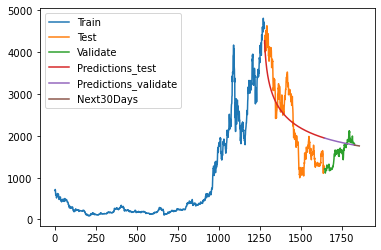

In [9]:
# ploting the actual values and predicted values
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_vpred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test','Validate', 'Predictions_test','Predictions_validate','Next30Days'])
plt.show()